In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df= pd.read_excel('Downloads/blame_dataset_v2.xlsx')
df = df.rename(columns={'Blame/Praise/Other' : 'Label'})
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,Illustration: Chen Xian/Global TimesUkraine is...,Other
1,Article 1,NaN,Sentence 2,Several European diplomats confirmed Tuesday t...,Other
2,Article 1,NaN,Sentence 3,In the context of the ongoing Russia-Ukraine c...,Other
3,Article 1,NaN,Sentence 4,"Apparently, the EU has been completely hijacke...",Blame
4,Article 1,NaN,Sentence 5,"Facing a dilemma, it had no choice but to open...",Blame


In [3]:
df.shape

(436, 5)

In [4]:
missing_values = df.isnull().sum()
print(missing_values)

Article ID           0
Article's topic    426
Sentence ID          0
Sentence             0
Label              224
dtype: int64


In [5]:
#check unique classes
df['Label'].unique()

array(['Other ', 'Blame', 'Blame/Praise', 'Blame ', 'Praise ', nan,
       'Blame / Praise', 'Blame  ', 'Criticism '], dtype=object)

In [6]:
df = df.dropna(subset=['Label']) #or use df = df[df['Label'].notna()]
df['Label'] = df['Label'].str.strip()
df = df[df['Sentence'].apply(lambda x: len(x.split()) >= 3)]
df = df[~df['Label'].isin(['Blame/Praise', 'Blame / Praise', 'Criticism'])]

In [7]:
df.shape

(194, 5)

In [8]:
df.Label.value_counts()

Label
Blame     99
Other     75
Praise    20
Name: count, dtype: int64

## Preprocessing

In [9]:
#Library import for preprocessing
pd.set_option('display.max_colwidth', None)
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Case Folding

In [10]:
df['Sentence'] = df['Sentence'].str.lower()
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,illustration: chen xian/global timesukraine is set to become an official candidate for european union (eu) membership at the eu summit to be held on thursday and friday.,Other
1,Article 1,NaN,Sentence 2,several european diplomats confirmed tuesday that no countries raised objections at a meeting of the bloc's ambassadors on monday.,Other
2,Article 1,NaN,Sentence 3,"in the context of the ongoing russia-ukraine conflict, ukraine's eu candidacy appears to be a symbolic decision, through which european countries have reaffirmed their political support for ukraine and encouraged the eastern european country to ""hang in there"" in the war.",Other
3,Article 1,NaN,Sentence 4,"apparently, the eu has been completely hijacked by nato and the us vis-à-vis this war.",Blame
4,Article 1,NaN,Sentence 5,"facing a dilemma, it had no choice but to open its arms to ukraine's membership, because supporting ukraine - no matter what - has become new ""political correctness"" in the west.",Blame


### Cleansing

In [11]:
def cleansing(sentences):
    # Remove specific links
    sentences = re.sub(r'\b(?:https?://|www\.)\S+\b', '', sentences)
    # Remove email addresses
    sentences = re.sub(r'\b(?:opinion@globaltimes\.com\.cn|dinggang@globaltimes\.com\.cn)\b', '', sentences)
    # Remove specific patterns like (photo: ...)
    sentences = re.sub(r'\(photo: (?:[a-zA-Z0-9]+\.[a-zA-Z]+|\S+)\)', '', sentences)
    # Remove specific patterns like note: ..., cartoon:...
    sentences = re.sub(r'\bphoto: \S+', '', sentences)
    sentences = re.sub(r'\billustration: \S+', '', sentences)
    sentences = re.sub(r'\bnote: \S+', '', sentences)
    sentences = re.sub(r'\bcartoon: \S+', '', sentences)
    # Remove possessive 's
    sentences = re.sub(r'\b\'s\b', '', sentences)
    # Remove \n characters
    sentences = sentences.replace('\n', ' ')
    # Remove other punctuation except "-"
    clean_sentences = re.sub(r'(@[A-Za-z0-9]+)|#[A-Za-z0-9]+|[^A-Za-z\s\'-]', ' ', sentences)
    return clean_sentences

In [12]:
df['Sentence'] = df['Sentence'].apply(cleansing)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine is set to become an official candidate for european union eu membership at the eu summit to be held on thursday and friday,Other
1,Article 1,NaN,Sentence 2,several european diplomats confirmed tuesday that no countries raised objections at a meeting of the bloc ambassadors on monday,Other
2,Article 1,NaN,Sentence 3,in the context of the ongoing russia-ukraine conflict ukraine eu candidacy appears to be a symbolic decision through which european countries have reaffirmed their political support for ukraine and encouraged the eastern european country to hang in there in the war,Other
3,Article 1,NaN,Sentence 4,apparently the eu has been completely hijacked by nato and the us vis- -vis this war,Blame
4,Article 1,NaN,Sentence 5,facing a dilemma it had no choice but to open its arms to ukraine membership because supporting ukraine - no matter what - has become new political correctness in the west,Blame


### Tokenization

In [13]:
def tokenize(sentences):
    return word_tokenize(sentences)

In [14]:
df['Sentence'] = df['Sentence'].apply(tokenize)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, is, set, to, become, an, official, candidate, for, european, union, eu, membership, at, the, eu, summit, to, be, held, on, thursday, and, friday]",Other
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirmed, tuesday, that, no, countries, raised, objections, at, a, meeting, of, the, bloc, ambassadors, on, monday]",Other
2,Article 1,NaN,Sentence 3,"[in, the, context, of, the, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appears, to, be, a, symbolic, decision, through, which, european, countries, have, reaffirmed, their, political, support, for, ukraine, and, encouraged, the, eastern, european, country, to, hang, in, there, in, the, war]",Other
3,Article 1,NaN,Sentence 4,"[apparently, the, eu, has, been, completely, hijacked, by, nato, and, the, us, vis-, -vis, this, war]",Blame
4,Article 1,NaN,Sentence 5,"[facing, a, dilemma, it, had, no, choice, but, to, open, its, arms, to, ukraine, membership, because, supporting, ukraine, -, no, matter, what, -, has, become, new, political, correctness, in, the, west]",Blame


### Stopword Removal

In [15]:
def stop_removal(sentences):
    words = stopwords.words('english')
    words = set(words)
    words.add("'s")
    return [word for word in sentences if word not in words]

In [16]:
df['Sentence'] = df['Sentence'].apply(stop_removal)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, set, become, official, candidate, european, union, eu, membership, eu, summit, held, thursday, friday]",Other
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirmed, tuesday, countries, raised, objections, meeting, bloc, ambassadors, monday]",Other
2,Article 1,NaN,Sentence 3,"[context, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appears, symbolic, decision, european, countries, reaffirmed, political, support, ukraine, encouraged, eastern, european, country, hang, war]",Other
3,Article 1,NaN,Sentence 4,"[apparently, eu, completely, hijacked, nato, us, vis-, -vis, war]",Blame
4,Article 1,NaN,Sentence 5,"[facing, dilemma, choice, open, arms, ukraine, membership, supporting, ukraine, -, matter, -, become, new, political, correctness, west]",Blame


### Lemmatization with POS Tagging

In [17]:
def lemmatize_pos(words, pos):
  lemmatizer = WordNetLemmatizer()

  pos_mapping = {
      'N': 'n',
      'V': 'v',
      'R': 'r',
      'J': 'a'
  }

  wordnet_pos = pos_mapping.get(pos[0], 'n')
  if wordnet_pos == 'n':
    return lemmatizer.lemmatize(words, pos='v')
  return lemmatizer.lemmatize(words, pos=wordnet_pos)

In [18]:
df['Sentence']  = df['Sentence'].apply(lambda x: [lemmatize_pos(words, pos) for words, pos in pos_tag(x)])
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, set, become, official, candidate, european, union, eu, membership, eu, summit, hold, thursday, friday]",Other
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirm, tuesday, countries, raise, objections, meet, bloc, ambassadors, monday]",Other
2,Article 1,NaN,Sentence 3,"[context, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appear, symbolic, decision, european, countries, reaffirm, political, support, ukraine, encourage, eastern, european, country, hang, war]",Other
3,Article 1,NaN,Sentence 4,"[apparently, eu, completely, hijack, nato, us, vis-, -vis, war]",Blame
4,Article 1,NaN,Sentence 5,"[face, dilemma, choice, open, arm, ukraine, membership, support, ukraine, -, matter, -, become, new, political, correctness, west]",Blame


## Label Encoder

In [19]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,"[xian, global, timesukraine, set, become, official, candidate, european, union, eu, membership, eu, summit, hold, thursday, friday]",1
1,Article 1,NaN,Sentence 2,"[several, european, diplomats, confirm, tuesday, countries, raise, objections, meet, bloc, ambassadors, monday]",1
2,Article 1,NaN,Sentence 3,"[context, ongoing, russia-ukraine, conflict, ukraine, eu, candidacy, appear, symbolic, decision, european, countries, reaffirm, political, support, ukraine, encourage, eastern, european, country, hang, war]",1
3,Article 1,NaN,Sentence 4,"[apparently, eu, completely, hijack, nato, us, vis-, -vis, war]",0
4,Article 1,NaN,Sentence 5,"[face, dilemma, choice, open, arm, ukraine, membership, support, ukraine, -, matter, -, become, new, political, correctness, west]",0


## Feature Extraction - TF-IDF

In [20]:
def join_text_list(texts):
    return ' '.join([text for text in texts])
df["Sentence"] = df["Sentence"].apply(join_text_list)
df.head()

,Article ID,Article's topic,Sentence ID,Sentence,Label
0,Article 1,Ukraine's membership in the EU & NATO,Sentence 1,xian global timesukraine set become official candidate european union eu membership eu summit hold thursday friday,1
1,Article 1,NaN,Sentence 2,several european diplomats confirm tuesday countries raise objections meet bloc ambassadors monday,1
2,Article 1,NaN,Sentence 3,context ongoing russia-ukraine conflict ukraine eu candidacy appear symbolic decision european countries reaffirm political support ukraine encourage eastern european country hang war,1
3,Article 1,NaN,Sentence 4,apparently eu completely hijack nato us vis- -vis war,0
4,Article 1,NaN,Sentence 5,face dilemma choice open arm ukraine membership support ukraine - matter - become new political correctness west,0


In [21]:
tf_idf = TfidfVectorizer(binary=True)
tfidf_mat = tf_idf.fit_transform(df["Sentence"]).toarray()

In [22]:
tfidf = pd.DataFrame(tfidf_mat, columns=tf_idf.get_feature_names_out())
tfidf.head()

,able,abort,abroad,absence,absolutely,accelerate,accepts,access,accord,account,...,xinhuachinese,xufeng,year,years,yet,yiwei,young,yousef,zhongping,zhu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X = tfidf.values
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
y = df['Label'].values
y[0:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

## Split Dataset

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#use stratify=y because data is imbalance
print("Train set: ", X_train.shape, y_train.shape)
print("Validation set: ", X_val.shape, y_val.shape)

Train set:  (155, 1116) (155,)
Validation set:  (39, 1116) (39,)


## Define Models

In [26]:
models = {
    'SVM': SVC(class_weight='balanced', kernel='linear', probability=True),
    'Naive Bayes': MultinomialNB()
}

## Train and Evaluate each Model

Training SVM...
SVM Classification Report:
              precision    recall  f1-score   support

       Blame       0.58      0.75      0.65        20
       Other       0.50      0.33      0.40        15
      Praise       0.67      0.50      0.57         4

    accuracy                           0.56        39
   macro avg       0.58      0.53      0.54        39
weighted avg       0.56      0.56      0.55        39

SVM Confusion Matrix:


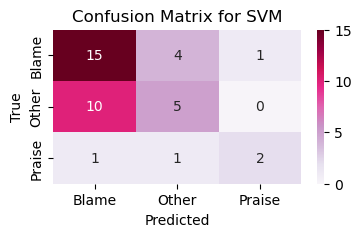

Training Naive Bayes...
Naive Bayes Classification Report:
              precision    recall  f1-score   support

       Blame       0.56      0.95      0.70        20
       Other       0.80      0.27      0.40        15
      Praise       0.00      0.00      0.00         4

    accuracy                           0.59        39
   macro avg       0.45      0.41      0.37        39
weighted avg       0.59      0.59      0.51        39

Naive Bayes Confusion Matrix:


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


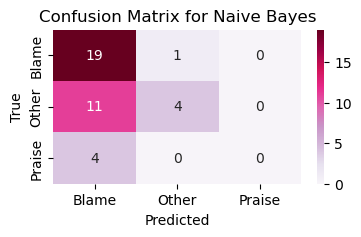

In [27]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    #train the model
    model.fit(X_train, y_train)
    
    #predict on the validation set
    y_pred = model.predict(X_val)
    
    #evaluate the model
    print(f"{model_name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
    
    #confusion matrix
    print(f"{model_name} Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
    
    #plot confusion matrix as heatmap
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

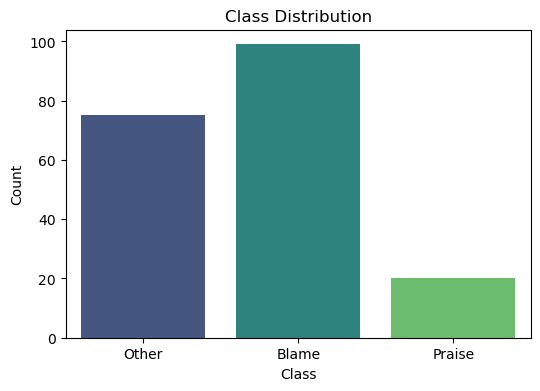

In [35]:
#Class distribution
label_mapping = {0: 'Blame', 1: 'Other', 2: 'Praise'}
df['Class Names'] = df['Label'].map(label_mapping)

colors = sns.color_palette('viridis', 3)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Class Names'], palette=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

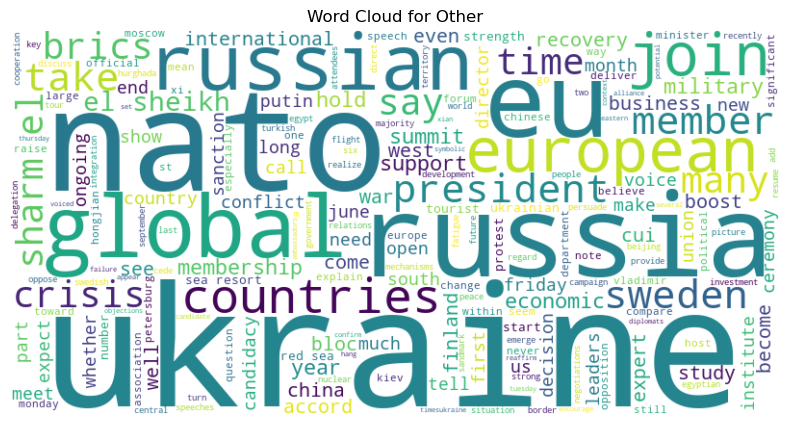

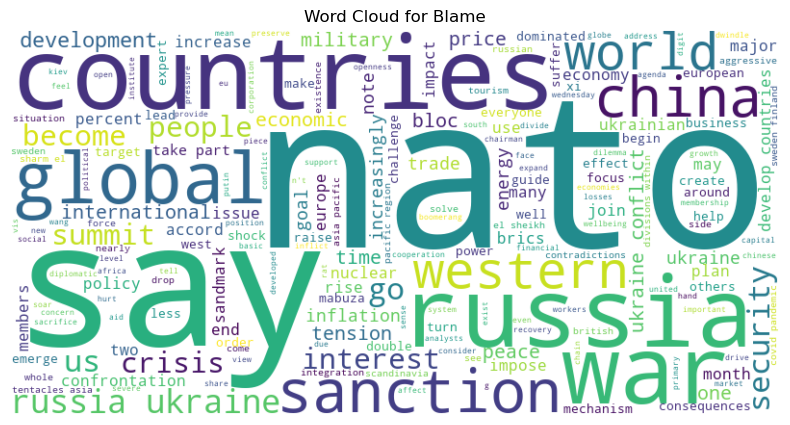

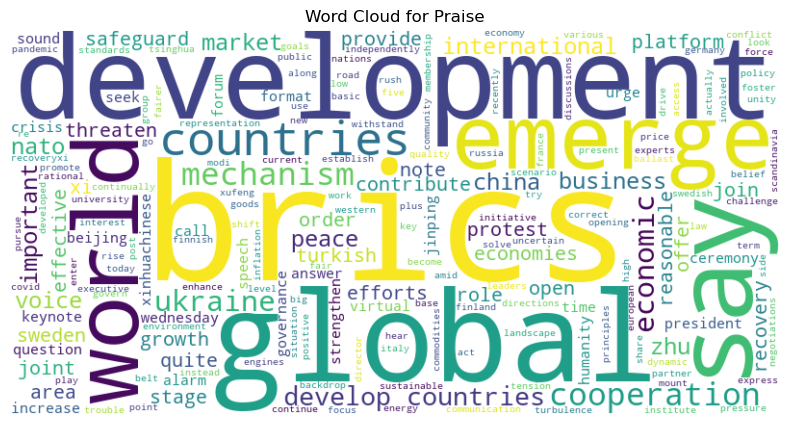

In [28]:
#generate word cloud for each class
labels = ['Blame', 'Other', 'Praise']

for label_num in df['Label'].unique():
    text_label = labels[label_num]
    text = " ".join(df[df['Label'] == label_num]['Sentence'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {text_label}")
    plt.axis('off')
    plt.show()

Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

       Blame       0.58      0.75      0.65        20
       Other       0.50      0.33      0.40        15
      Praise       0.67      0.50      0.57         4

    accuracy                           0.56        39
   macro avg       0.58      0.53      0.54        39
weighted avg       0.56      0.56      0.55        39

SVM Confusion Matrix:


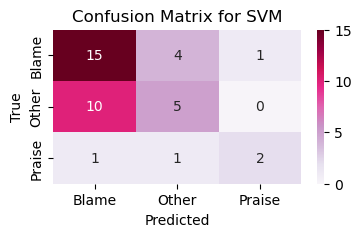

SVM Performance Metrics:
Accuracy: 0.5641
F1 Score: 0.5641
Precision: 0.5641
Recall: 0.5641
--------------------------------------------------
Training Naive Bayes...

Naive Bayes Classification Report:
              precision    recall  f1-score   support

       Blame       0.56      0.95      0.70        20
       Other       0.80      0.27      0.40        15
      Praise       0.00      0.00      0.00         4

    accuracy                           0.59        39
   macro avg       0.45      0.41      0.37        39
weighted avg       0.59      0.59      0.51        39

Naive Bayes Confusion Matrix:


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


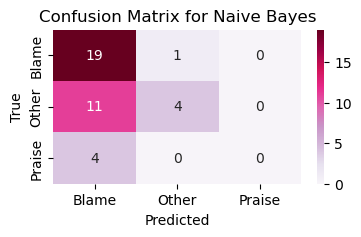

Naive Bayes Performance Metrics:
Accuracy: 0.5897
F1 Score: 0.5897
Precision: 0.5897
Recall: 0.5897
--------------------------------------------------


In [30]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Evaluate the model using classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    print(f"{model_name} Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Calculate additional metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='micro')
    precision = precision_score(y_val, y_pred, average='micro')
    recall = recall_score(y_val, y_pred, average='micro')

    # Print the additional metrics
    print(f"{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("-" * 50)